# EJEMPLO
medidas de dependencia en datos 2D con:
- correlación
- HSIC, nHSIC, linHSIC
- MI (con RBIG)

In [1]:
# Importamos las librerias necesarias
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tqdm.notebook import trange
import scipy

# Definición de las medidas

### HSIC y nHSIC en TF
Code adapted from:
https://github.com/romain-lopez/HCV/blob/master/hcv.py

In [2]:
from scipy.special import gamma
import tensorflow as tf
import numpy as np

def bandwidth(d):
    """
    in the case of Gaussian random variables and the use of a RBF kernel,
    this can be used to select the bandwidth according to the median heuristic
    """
    gz = 2 * gamma(0.5 * (d+1)) / gamma(0.5 * d)
    return 1. / (2. * gz**2)

def K(x1, x2, gamma=1.):
    dist_table = tf.expand_dims(x1, 0) - tf.expand_dims(x2, 1)
    return tf.transpose(tf.exp(-gamma * tf.reduce_sum(dist_table **2, axis=2)))


def hsic(z, s):
    s = tf.cast(s,'float32')
    s = tf.convert_to_tensor(s)

    z = tf.cast(z,'float32')
    z = tf.convert_to_tensor(z)

    # use a gaussian RBF for every variable

    d_z = z.get_shape().as_list()[1]
    d_s = s.get_shape().as_list()[1]

    zz = K(z, z, gamma= bandwidth(d_z))
    ss = K(s, s, gamma= bandwidth(d_s))


    hsic = 0
    hsic += tf.reduce_mean(zz * ss)
    hsic += tf.reduce_mean(zz) * tf.reduce_mean(ss)
    hsic -= 2 * tf.reduce_mean( tf.reduce_mean(zz, axis=1) * tf.reduce_mean(ss, axis=1) )

    return tf.sqrt(hsic)

def nhsic(z, s):
    s = tf.cast(s,'float32')
    s = tf.convert_to_tensor(s)

    z = tf.cast(z,'float32')
    z = tf.convert_to_tensor(z)
    # use a gaussian RBF for every variable

    d_z = z.get_shape().as_list()[1]
    d_s = s.get_shape().as_list()[1]

    K1 = K(z, z, gamma= bandwidth(d_z))
    K2 = K(s, s, gamma= bandwidth(d_s))

    return tf.reduce_sum(K1 * K2) / tf.norm(K1) / tf.norm(K2)

### Correlación de Pearson en TF

In [3]:
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = tf.reduce_mean(x)
    my = tf.reduce_mean(y)
    xm, ym = x - mx, y - my
    t1_norm = tf.nn.l2_normalize(xm)
    t2_norm = tf.nn.l2_normalize(ym)
    cosine_loss = tf.keras.losses.CosineSimilarity()
    cosine = -cosine_loss(t1_norm, t2_norm)
    return cosine

### RBIG (no en TF)

In [4]:
!pip install "git+https://github.com/IPL-UV/rbig.git"

  Cloning https://github.com/IPL-UV/rbig.git to /tmp/pip-req-build-4ijhn98f
  Running command git clone --filter=blob:none --quiet https://github.com/IPL-UV/rbig.git /tmp/pip-req-build-4ijhn98f
  Resolved https://github.com/IPL-UV/rbig.git to commit a9124fc07d8e851833802d604fe552b6327ab980
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
  Created wheel for py-rbig: filename=py_rbig-0.0.1-py3-none-any.whl size=17469 sha256=905e816addd1552333ef91bee0ccca6be29c853f2cbbba814cbe47ad4465f98f
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fva_yop/wheels/49/be/80/0285fa4ec7c96e2c9a8c8bcb0cd0330a26e0ce7fbb4b5afc19
Successfully built py-rbig


In [5]:
!pip install python-picard

In [6]:
from rbig._src.mutual_info import MutualInfoRBIG

/usr/local/lib/python3.10/dist-packages/rbig/_src/training.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [7]:
rbig_model = MutualInfoRBIG()

# Data Toy non-linear regression

In [8]:
# number of data points
N = 1000

x_train = np.random.randn(N,2)
y_train = x_train.copy()
y_train[:,0] = (2 * x_train[:,0])**2 + np.random.randn(N,)
y_train[:,1] = (2 * x_train[:,1])**2 + np.random.randn(N,)


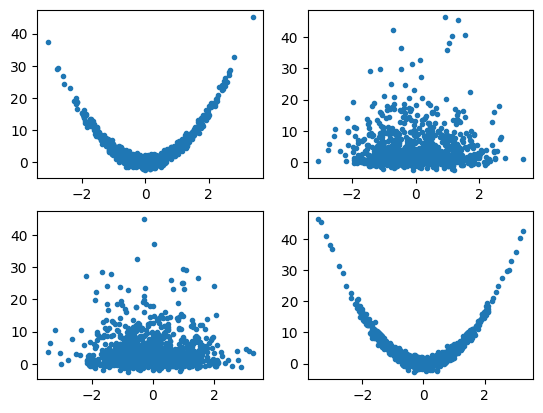

In [9]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(x_train[:,0],y_train[:,0],'.')

plt.subplot(2,2,2)
plt.plot(x_train[:,0],y_train[:,1],'.')

plt.subplot(2,2,3)
plt.plot(x_train[:,1],y_train[:,0],'.')

plt.subplot(2,2,4)
plt.plot(x_train[:,1],y_train[:,1],'.')

In [10]:
y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

# Aplicación de las medidas

Correlación

In [11]:
# pearson correlation per dimension
C_xx = x_train.T @ x_train
C_yy = y_train.T @ y_train
C_xy = x_train.T @ y_train
hs_score_xy = np.linalg.norm(C_xy, ord='fro')
hs_score_xy_norm = hs_score_xy/(np.linalg.norm(C_xx, ord='fro')*np.linalg.norm(C_yy, ord='fro'))

corr_spearman_scipy = scipy.stats.spearmanr(x_train,y_train)[0]
hs_sp_score = np.linalg.norm(corr_spearman_scipy, ord='fro')

HSIC

In [12]:
C_xy = c_xy = x_train.T @ y_train
hsic_lin = np.sqrt(np.sum(C_xy * C_xy))

In [13]:
hsic_tf = hsic(x_train,y_train).numpy()
nhsic_tf = nhsic(x_train,y_train).numpy()

RBIG

In [14]:
rbig_model.fit(x_train,y_train);
mi_rbig = rbig_model.mutual_info() * np.log(2)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# Results

In [15]:
print('hs score xy: ' + str(hs_score_xy))
print('hs score xy norm: ' + str(hs_score_xy_norm))
print('hs score xy spearman: ' + str(hs_sp_score))
print('hsic lin: ' + str(hsic_lin))
print('hsic: ' + str(hsic_tf))
print('nhsic: ' + str(nhsic_tf))
print('MI (RBIG): ' + str(mi_rbig))

hs score xy: 1006.6322
hs score xy norm: 9.3996005e-06
hs score xy spearman: 2.0061033780460913
hsic lin: 1006.6322
hsic: 0.073298216
nhsic: 0.565213
MI (RBIG): 0.41206073431997664


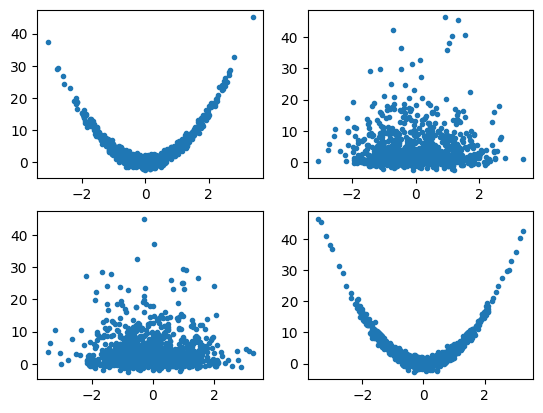

In [16]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(x_train[:,0],y_train[:,0],'.')

plt.subplot(2,2,2)
plt.plot(x_train[:,0],y_train[:,1],'.')

plt.subplot(2,2,3)
plt.plot(x_train[:,1],y_train[:,0],'.')

plt.subplot(2,2,4)
plt.plot(x_train[:,1],y_train[:,1],'.')

# Data Toy non-linear regression

In [17]:
# number of data points
N = 1000

x_train = np.random.randn(N,2)
y_train = x_train.copy()
y_train[:,0] = (2 * x_train[:,0])**2 + 3*np.random.randn(N,)
y_train[:,1] = (2 * x_train[:,1])**2 + 3*np.random.randn(N,)


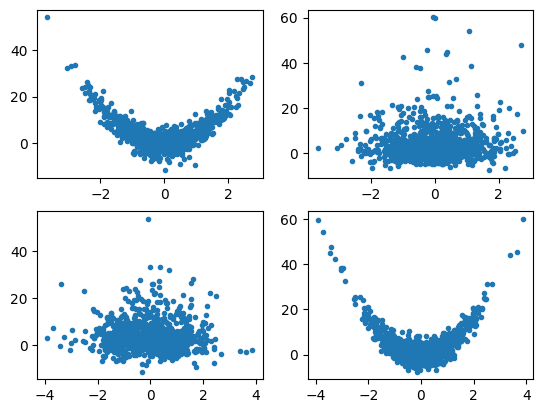

In [18]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(x_train[:,0],y_train[:,0],'.')

plt.subplot(2,2,2)
plt.plot(x_train[:,0],y_train[:,1],'.')

plt.subplot(2,2,3)
plt.plot(x_train[:,1],y_train[:,0],'.')

plt.subplot(2,2,4)
plt.plot(x_train[:,1],y_train[:,1],'.')

In [19]:
y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

# Aplicación de las medidas

Correlación

In [20]:
# pearson correlation per dimension
C_xx = x_train.T @ x_train
C_yy = y_train.T @ y_train
C_xy = x_train.T @ y_train
hs_score_xy = np.linalg.norm(C_xy, ord='fro')
hs_score_xy_norm = hs_score_xy/(np.linalg.norm(C_xx, ord='fro')*np.linalg.norm(C_yy, ord='fro'))

corr_spearman_scipy = scipy.stats.spearmanr(x_train,y_train)[0]
hs_sp_score = np.linalg.norm(corr_spearman_scipy, ord='fro')

HSIC

In [21]:
C_xy = c_xy = x_train.T @ y_train
hsic_lin = np.sqrt(np.sum(C_xy * C_xy))

In [22]:
hsic_tf = hsic(x_train,y_train).numpy()
nhsic_tf = nhsic(x_train,y_train).numpy()

RBIG

In [ ]:
rbig_model.fit(x_train,y_train);
mi_rbig = rbig_model.mutual_info() * np.log(2)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# Results

In [ ]:
print('hs score xy: ' + str(hs_score_xy))
print('hs score xy norm: ' + str(hs_score_xy_norm))
print('hs score xy spearman: ' + str(hs_sp_score))
print('hsic lin: ' + str(hsic_lin))
print('hsic: ' + str(hsic_tf))
print('nhsic: ' + str(nhsic_tf))
print('MI (RBIG): ' + str(mi_rbig))

In [ ]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(x_train[:,0],y_train[:,0],'.')

plt.subplot(2,2,2)
plt.plot(x_train[:,0],y_train[:,1],'.')

plt.subplot(2,2,3)
plt.plot(x_train[:,1],y_train[:,0],'.')

plt.subplot(2,2,4)
plt.plot(x_train[:,1],y_train[:,1],'.')